In [35]:
setwd('/fs/cbcb-lab/rob/students/noor/Uncertainity/treeTerminusScripts')

suppressPackageStartupMessages(source("tree_helper_function.R"))
suppressPackageStartupMessages(source("tree_term_climb.R"))
suppressPackageStartupMessages(library(beaveR))
suppressPackageStartupMessages(library("ggtree"))
suppressPackageStartupMessages(library("grid"))
suppressPackageStartupMessages(library("ggplotify"))
suppressPackageStartupMessages(library("ggpubr"))

quantDir <- "/fs/cbcb-scratch/jfan03/treeterm-paper/output/seed=1_fc=2:6/post_type=gibbs_nrep=100_tf=100/salmon_quants"
saveDir <- "environment/brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/comp_trees_updated_sim"
samples <- as.vector(outer(c(1:6), c(1,2), function(x,y) paste(x,y,sep="_")))
                           
files <- file.path(quantDir, samples, "quant.sf")
coldata <- data.frame(files = files, names = samples, condition = as.factor(rep(c(1,2),each=6)))
clustFile <- "/fs/cbcb-scratch/jfan03/treeterm-paper/output/seed=1_fc=2:6/post_type=gibbs_nrep=100_tf=100/terminus/no_threshold0/cluster_nwk.txt"
tseCons <- buildTSE(treeTermFile = clustFile, coldata = coldata)
treeCons <- rowTree(tseCons)
l <- length(treeCons$tip)
termFile <- "/fs/cbcb-scratch/jfan03/treeterm-paper/output/seed=1_fc=2:6/post_type=gibbs_nrep=100_tf=100/terminus/old/1_1/clusters.txt"
                           
load("treeDE_Paper_Images/brain_sim_nodtu/detNodes.RData")
load("treeDE_Paper_Images/brain_sim_nodtu/negNodes.RData")

reading tree

importing quantifications

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 


found matching transcriptome:
[ GENCODE - Homo sapiens - release 26 ]

loading existing TxDb created: 2023-03-02 17:08:07

loading existing transcript ranges created: 2023-03-02 21:45:10

Missing txps 3817

Aggregation Started

Aggregation Ended



In [36]:
load("/fs/cbcb-scratch/jfan03/treeterm-paper/output/seed=1_fc=2:6/sim_expr.rda")
suppressPackageStartupMessages(library(TreeSummarizedExperiment))
suppressPackageStartupMessages(library(ape))

missingTxps <- setdiff(treeCons$tip.label, rownames(sim.counts.mat))
dts <- Reduce(union, c(names(iso.dge)[iso.dge], names(iso.dte)[iso.dte], names(iso.dte.only)[iso.dte.only], 
                       names(iso.dtu)[iso.dtu]))
dts <- intersect(dts, rownames(sim.counts.mat))
sim.counts.mat <- rbind(sim.counts.mat, matrix(0, nrow = length(missingTxps), ncol = ncol(sim.counts.mat),
                                               dimnames = list(missingTxps, colnames(sim.counts.mat))))
sim.counts.mat <- sim.counts.mat[treeCons$tip.label,]
dts <- intersect(dts, rownames(sim.counts.mat))

innNodes <- l+1:treeCons$Nnode
aggCountsNodes <- computeAggNodesU(treeCons, c(1:length(treeCons$tip),innNodes), sim.counts.mat)
logFCNodes <- ifelse(rowSums(aggCountsNodes)==0, 0, log2(aggCountsNodes[,2]+1)-log2(aggCountsNodes[,1]+1))
names(logFCNodes)[(l+1):length(logFCNodes)] <- paste("Node", names(logFCNodes)[(l+1):length(logFCNodes)], sep="")
rootFC <- abs(logFCNodes[l+1])

### Transcript level DE

In [3]:
y <- fishpond::scaleInfReps(tseCons[1:l,])
y <- labelKeep(y)
set.seed(10)
y <- swish(y,x="condition")

### For all the nodes in the tree

In [4]:
set.seed(10)
yA <- computeSizeFactors(tseCons)
yA <- scaleInfReps(yA)
yInn <- swish(yA[(l+1):nrow(tseCons),], x="condition")
mcols(yA)[["pvalue"]] <- c(mcols(y)[["pvalue"]], mcols(yInn)[["pvalue"]])
infReps <- fishpond:::getInfReps(yA)
lfc <- fishpond:::getLog2FC(infReps,condition=colData(yA)[["condition"]])
mcols(yA)[["log2FC"]] <- lfc

Setting inf rep depth to mean depth



Progress:   1 on 100Progress:   2 on 100Progress:   3 on 100Progress:   4 on 100Progress:   5 on 100Progress:   6 on 100Progress:   7 on 100Progress:   8 on 100Progress:   9 on 100Progress:  10 on 100Progress:  11 on 100Progress:  12 on 100Progress:  13 on 100Progress:  14 on 100Progress:  15 on 100Progress:  16 on 100Progress:  17 on 100Progress:  18 on 100Progress:  19 on 100Progress:  20 on 100Progress:  21 on 100Progress:  22 on 100Progress:  23 on 100Progress:  24 on 100Progress:  25 on 100Progress:  26 on 100Progress:  27 on 100Progress:  28 on 100Progress:  29 on 100Progress:  30 on 100Progress:  31 on 100Progress:  32 on 100Progress:  33 on 100Progress:  34 on 100Progress:  35 on 100Progress:  36 on 100Progress:  37 on 100Progress:  38 on 100Progress:  39 on 100Progress:  40 on 100Progress:  41 on 100Progress:  42 on 100Progress:  43 on 100Progress:  44 on 100Progress:  45 on 100Progress:  46 on 100Progress:  47 on 100Progress:  48 on 100Progress:  49 on 100Progress:  50 on 100

### Terminus

In [52]:
suppressPackageStartupMessages(source("old_terminus_helper.R"))
yTermThrNS <- tseCons[1:l,]
groupsClust <- parseClustFile(termFile, yTermThrNS)
mInds <- seq(nrow(yTermThrNS) + length(groupsClust))
yAggTermThrNS <- prepOSwish(yTermThrNS, mInds, groupsClust)
yTerm <- yAggTermThrNS[-unlist(groupsClust),]
yTerm <- fishpond::scaleInfReps(yTerm)
yTerm <- labelKeep(yTerm)
yTerm <- swish(yTerm, x="condition")
lTerm <- l-length(unlist(groupsClust))

In [6]:
aggCountsNodes <- computeOAggNodesU(groupsClust, mInds, sim.counts.mat)
logFCNodesTerm <- ifelse(rowSums(aggCountsNodes)==0, 0, log2(aggCountsNodes[,2]+1)-log2(aggCountsNodes[,1]+1))

In [ ]:
detNodes[["term"]] <- lapply(c(0.01, 0.05, 0.1), function(x) {
        nodes <- rownames(yTerm)[which(mcols(yTerm)[,"qvalue"] <= x)]
        match(nodes, names(logFCNodesTerm))
    })
negNodes[["term"]] <- lapply(c(0.01, 0.05, 0.1), function(x) {
        nodes <- rownames(yTerm)[setdiff(seq(nrow(yTerm)),
                                                 which(mcols(yTerm)[,"qvalue"] <= x))]
        match(nodes, names(logFCNodesTerm))
    })

In [53]:
lapply(detNodes[["term"]],length)
sapply(lapply(lapply(c(0.01,0.05,0.1), 
                     function(x) rownames(yTerm)[which(mcols(yTerm)[,"qvalue"] <= x)]),
                     function(nodes) match(nodes, names(logFCNodesTerm))),length)

[[1]]
[1] 4926

[[2]]
[1] 6109

[[3]]
[1] 6832

[1] 4868 6038 6718

In [41]:
 length(rownames(yTerm)[which(mcols(yTerm)[,"qvalue"] <= 0.01)])
length(detNodes$term[[1]])

[1] 4925

[1] 4926

### Comparison treeDE with Terminus

It might that either of the node (treeDE or Terminus) might be a TP but we are only focusing on their transcripts that are true TPs

In [7]:
treeDETxps <- rownames(tseCons)[unlist(Descendants(treeCons, detNodes[["treeDEFDR_OL"]][[1]]))]
dN <- detNodes[["term"]][[1]]
termTxps <- c(names(logFCNodesTerm)[dN][startsWith(names(logFCNodesTerm)[dN], "ENS")],
  names(logFCNodesTerm)[as.numeric(unlist(groupsClust[names(logFCNodesTerm)[dN][!startsWith(names(logFCNodesTerm)[dN], "ENS")]]))])


In [8]:
length(setdiff(termTxps, treeDETxps)) ## unique to Terminus
length(setdiff(treeDETxps, termTxps)) ## unique to treeDE
length(intersect(dts, setdiff(treeDETxps, termTxps))) ## unique to treeDE but true
length(intersect(dts, setdiff(termTxps, treeDETxps))) ## unique to term but true

[1] 162

[1] 1423

[1] 695

[1] 28

#### Unique to terminus

In [9]:
tt <- match(intersect(dts, setdiff(termTxps, treeDETxps)), names(logFCNodes))
gL <- unique(sapply(tt, function(txp) {
    for(i in seq_along(groupsClust)) {
        if(sum(txp %in% groupsClust[[i]]) > 0)
            return(i)
    }
}))
length(gL) ### The unique Terminus txps belong to these many groups (23)

[1] 23

#### Unique to treeDE

In [10]:
trueTreeDE <- intersect(dts, setdiff(treeDETxps, termTxps))
termTxpsM <- lapply(groupsClust, function(x) rownames(yTermThrNS)[x])  ## Term groups with ids

treeDEinTerm <- sapply(trueTreeDE, function(x) { ## txps belonging to treeDE that are in Terminus groups
    for(i in seq_along(termTxpsM)) {
        if(x %in% termTxpsM[[i]])
            return(i)
    }
    return(-1)
})
                    
sum(treeDEinTerm != -1) ## 59 cases of true treeDE txps that are also covered by terminus groups but not de in terminus

## All the txps that are not covered are definitely under-aggregated
## It is overaggregation when txp is in Term group but has a cand ancestor 
## that has less number of txps compared to Terminus

txpsPlausOverAgg <- trueTreeDE[treeDEinTerm!=-1] ## all the desc cand txps that have a matching in Term
treeDEinTerm <- treeDEinTerm[treeDEinTerm != -1] ## the index of term group where the above match occurs

overAgg <- list()  ##Overagg in Term Tuple candTreeDENode, groupClustInd, number of txps in Term group
underAgg <- list() ##Underagg in Term Tuple candTreeDENode, groupClustInd, number of txps in Term group
sAgg <- list()
oj <- 1
uj <- 1
sj <- 1
j <- 1 ## index for node list
for(i in seq_along(txpsPlausOverAgg)) {
    tInd <- match(txpsPlausOverAgg[i], treeCons$tip) ## index of txp
    sigT <- c(tInd, Ancestors(treeCons, tInd)) ## finding which one of ancestor or txp is a cand node
    sigT <- sigT[sigT %in% detNodes[["treeDEFDR_OL"]][[j]]]
    if(length(sigT) != 1)
        stop(paste(i, "multiple thus error"))
    if(length(unlist(Descendants(treeCons, sigT))) < length(groupsClust[[treeDEinTerm[i]]])) { ## overaggregated
        overAgg[[oj]] <- c(sigT, treeDEinTerm[[i]], length(groupsClust[[treeDEinTerm[i]]]))
        oj <- oj + 1
    }
    else if(length(unlist(Descendants(treeCons, sigT))) > length(groupsClust[[treeDEinTerm[i]]])) {
        underAgg[[uj]] <- c(sigT, treeDEinTerm[[i]], length(groupsClust[[treeDEinTerm[i]]]))
        uj <- uj + 1
    }
    else {
        sAgg[[sj]] <- c(sigT, treeDEinTerm[[i]], length(groupsClust[[treeDEinTerm[[i]]]]))
        sj <- sj + 1
    }

}

[1] 59

In [11]:
### Number of overaggregated unique tp transcripts belonging to treeDE for which in Terminus there exists a Terminus group
length(overAgg)
### Out of these how many are inner nodes in treeDE
overAgg[which(sapply(overAgg, function(g) g[1]) > l)]
og <- sapply(overAgg, function(g) g[1])

[1] 29

[[1]]
[1] 184129   5237      5

[[2]]
[1] 164590   4965      4

In [12]:
### Number of txp groups in treeDE for which there exists a group in Terminus but is underaggregated
length(underAgg)
ug1 <- unique(sapply(underAgg, function(g) g[1])) ## Unique groups
length(ug1)

[1] 30

[1] 21

In [13]:
descug <- Descendants(treeCons, ug1) ## It might happen that the candidate treeDE node in the underaggregated Terminus group 
## might have an underlying txp that is DTE when doing differential analysis with the Terminus groups
ug1 <- ug1[sapply(descug, function(txps) {
    txps <- treeCons$tip[txps]
    if(sum(txps %in% termTxps) > 0)
        return(FALSE)
    return(TRUE)
})]
length(ug1)
underAgg <- underAgg[sapply(underAgg, function(ug) ug[1] %in% ug1)]

[1] 5

In [14]:
### The remaining transcripts unique to treeDE are also overaggregated and extracting their candidate nodes
remOverAggTxps <- match(setdiff(trueTreeDE, txpsPlausOverAgg), treeCons$tip)
ancs <- Ancestors(treeCons, remOverAggTxps)
length(remOverAggTxps)
cNodes <- sapply(seq_along(ancs), function(i) {
    tt <- c(remOverAggTxps[i], ancs[[i]])
    tt[tt %in% detNodes[["treeDEFDR_OL"]][[j]]]
})
length(cNodes)
cNodes <- unique(cNodes)
length(cNodes)
sum(cNodes > l)

cNodesU <- cNodes[sapply(Descendants(treeCons, cNodes), function(txps) {
    sum(treeCons$tip[txps] %in% termTxps) == 0
})]
length(cNodesU) ## Not even a single descendant is considered sig by Terminus, for others, atleast one sibling might be considered significant

[1] 636

[1] 636

[1] 441

[1] 389

[1] 91

In [15]:
#### Overall unique nodes belonging to treeDE
untreeDE <- unique(c(ug1, cNodes, og)) ## not 480 from 5+441+29
length(untreeDE)

[1] 471

In [16]:
term <- sapply(overAgg, function(x) x[2])

#### OverAgg examples

In [17]:
og[order(abs(mcols(yA)[og,"log2FC"]), decreasing=T)]
term[order(abs(mcols(yA)[og,"log2FC"]), decreasing=T)]
og[og > l]

[1]  33791  83836 112813  32760 113900  63884  31689  32403  33275  23940
[11]   5005 120588  74755 103905  51115  85724  30382 112143  81772  95157
[21] 164590 184129  19633  18583 123969  28864  13040 118196 105286

[1] 5429  154  462 2103 5181 4716 1863  235 1280 4477 5144 4116  454 3017 5291
[16]  735 3593 4205 2679 5091 4965 5237 2337 1013  443 4185 5446 1505 1130

[1] 184129 164590

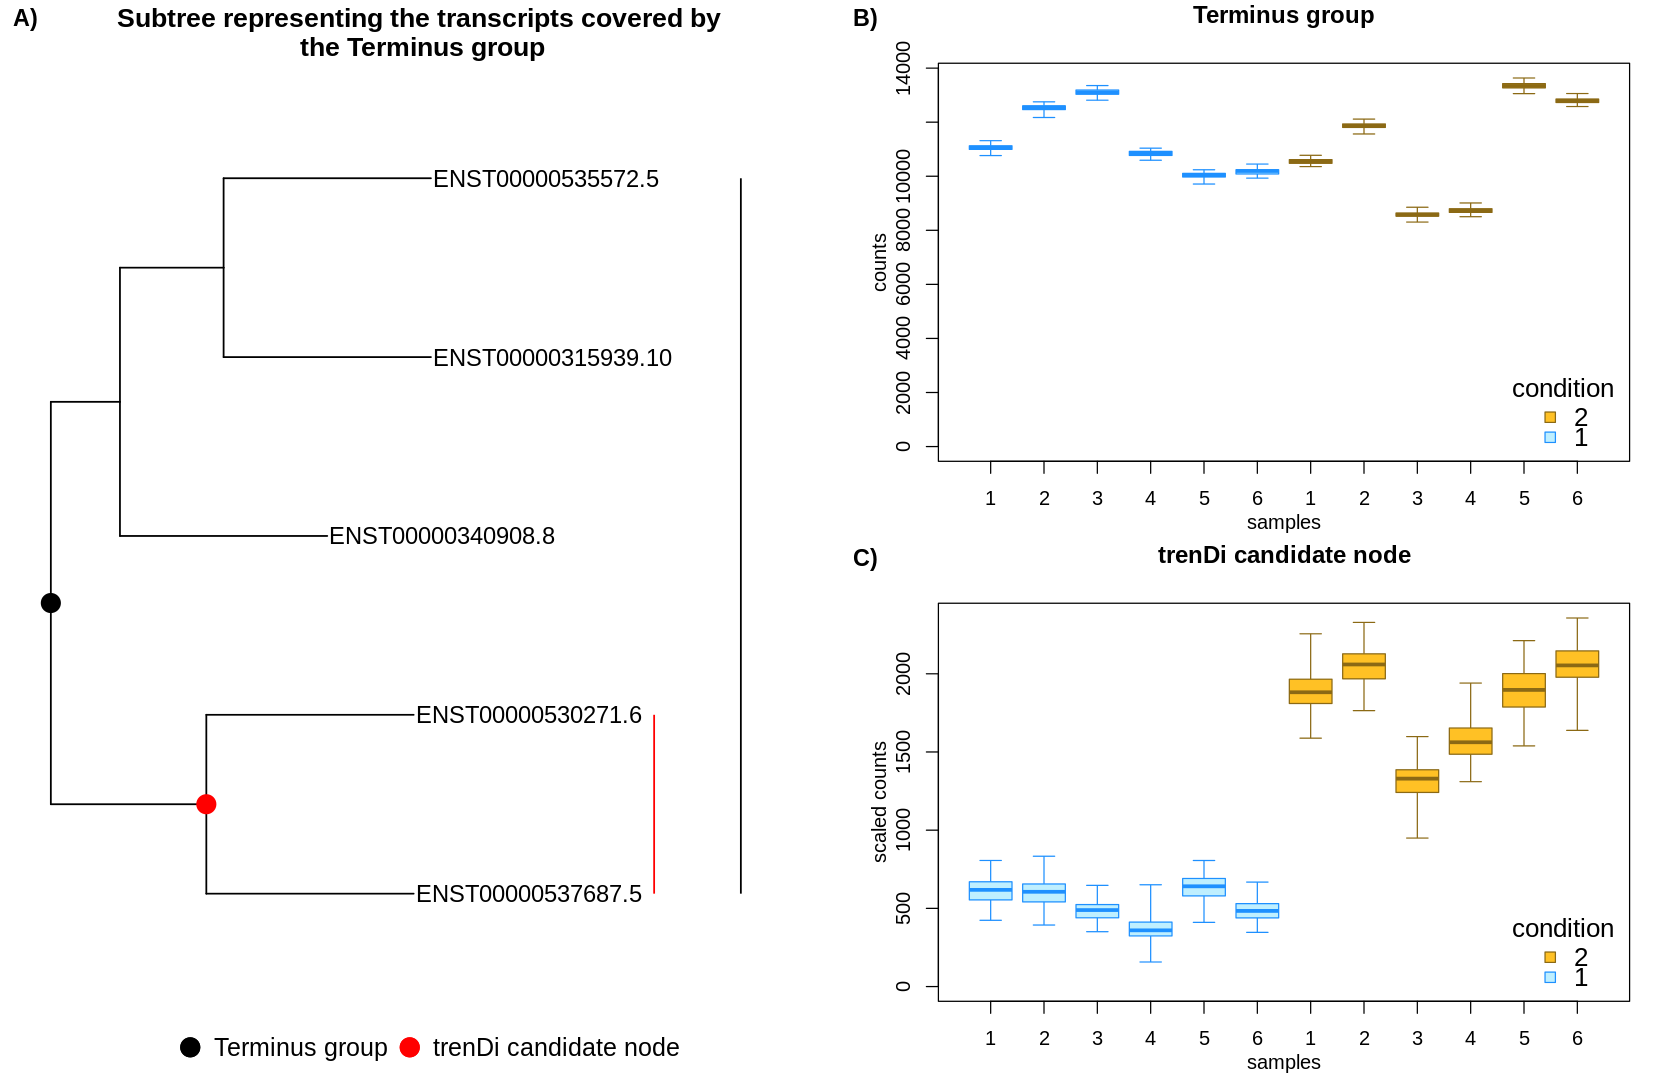

In [21]:
options(repr.plot.width=14, repr.plot.height=9)
cNode <- 184129
tNode <- 5237
treeSub <- treeio::tree_subset(treeCons, Ancestors(treeCons,cNode)[1], levels_back = 0)

of=13.5
pTree <- ggtree(treeSub) + ggtitle("Subtree representing the transcripts covered by \nthe Terminus group") +
    xlim(NA, 43) +
    geom_tiplab(size=5) +
    geom_point2(aes(subset=(node==7), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==6), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = 7, label = "", textcolour="red", 
                  barcolour="red",  fontsize=5, offset = of) + 
    geom_cladelab(node = 6, label = "", textcolour="black",
                  fontsize=5, offset = of+4) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Terminus group", "trenDi candidate node"),
           values=c("black","red"))

pTerm <- as.grob(~plotInfReps(yAggTermThrNS, as.character(l+tNode), x = "condition", legend = TRUE,
                       main="Terminus group", legendTitle=TRUE, legendCex=1.3,
                       legendPos = "bottomright"))
pTreeTerm <- as.grob(~plotInfReps(yA, cNode, x = "condition", legend=TRUE,
                              main="trenDi candidate node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "bottomright"))
ggarrange(pTree, ggarrange(pTerm, pTreeTerm, ncol = 1, labels = c("B)", "C)")), labels="A)")

[1] 8

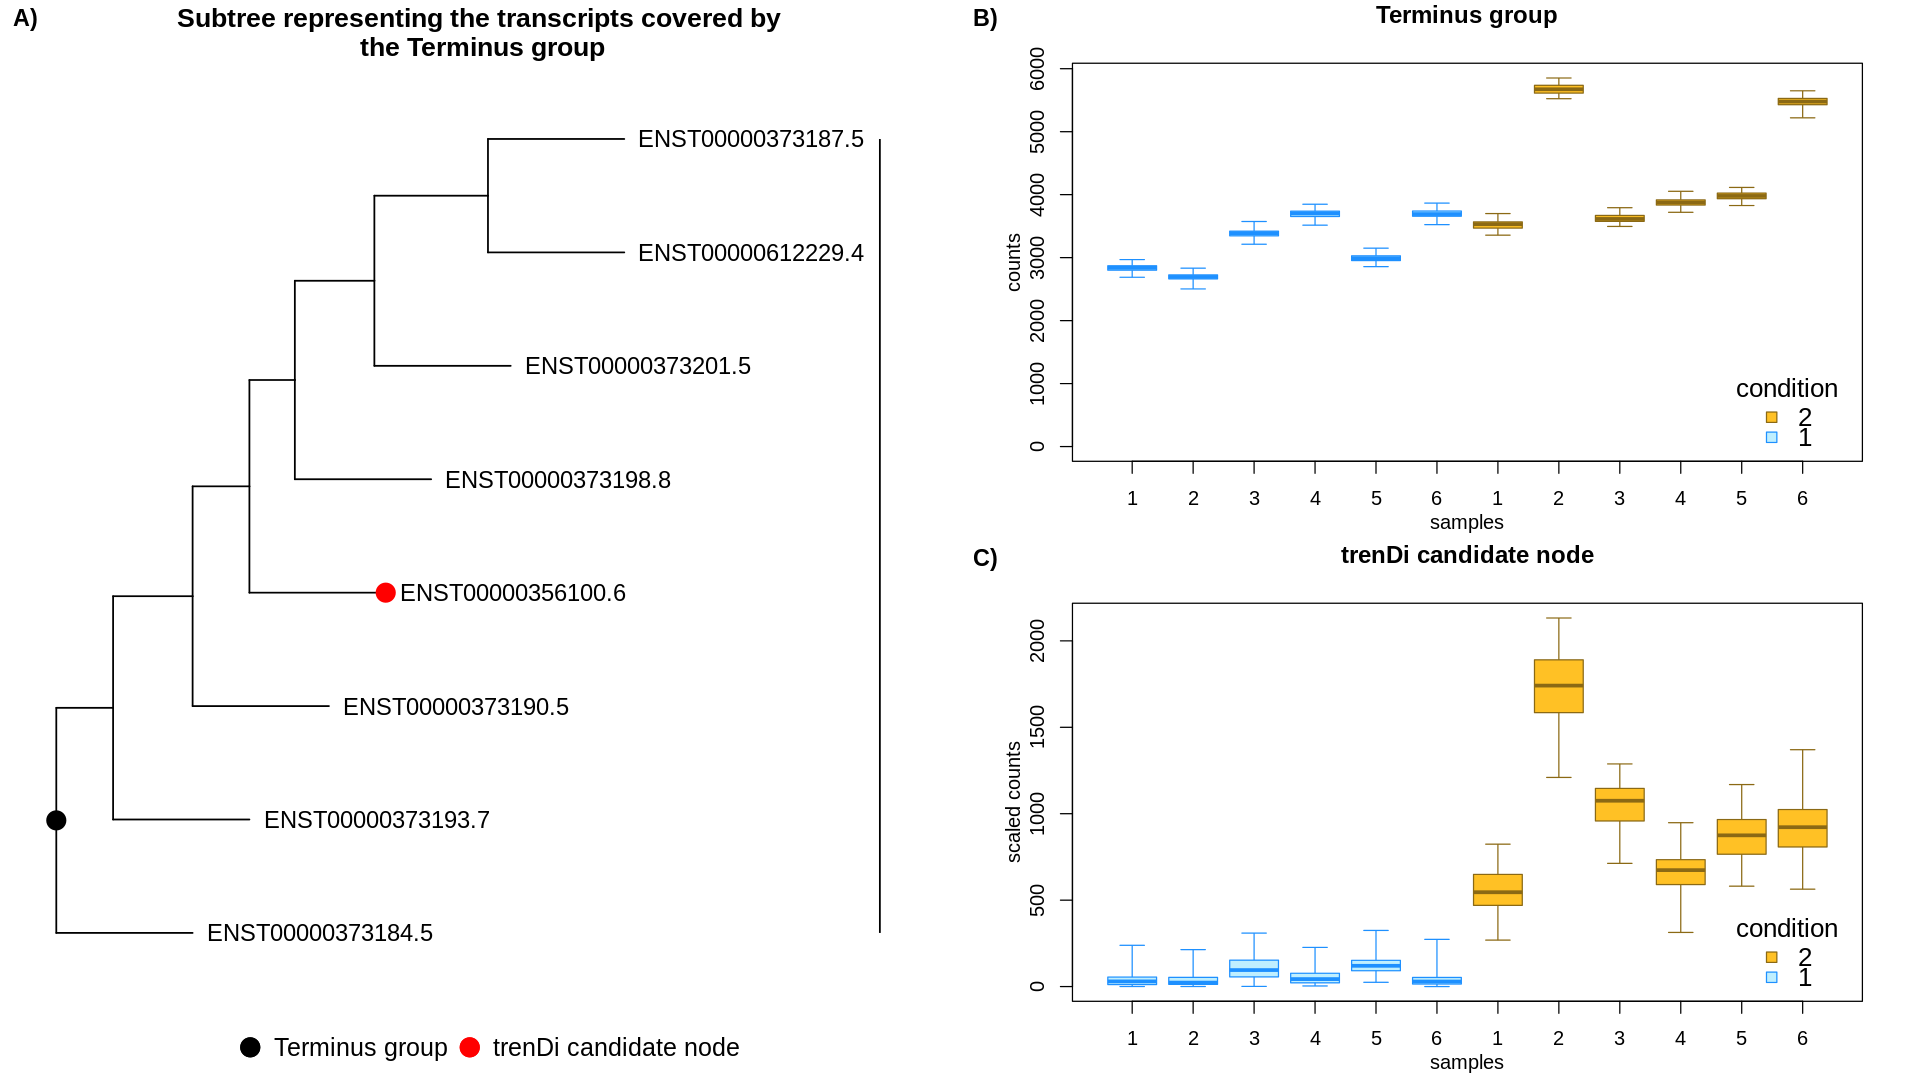

In [22]:
options(repr.plot.width=16, repr.plot.height=9)
cNode <- 33791
tNode <- 5429

treeSub <- treeio::tree_subset(treeCons, Ancestors(treeCons,cNode)[4], levels_back = 0)
lNode <- match(treeCons$tip[cNode], treeSub$tip)
iNode <- length(treeSub$tip)+1
length(groupsClust[[tNode]])
of=13.5
pTree <- ggtree(treeSub) + ggtitle("Subtree representing the transcripts covered by \nthe Terminus group") +
    xlim(NA, 75) +
    geom_tiplab(size=5,hjust=-0.05) +
    geom_point2(aes(subset=(node==lNode), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==iNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = lNode, label = "", textcolour="red", 
                  barcolour="red",  fontsize=5, offset = of) + 
    geom_cladelab(node = iNode, label = "", textcolour="black",
                  fontsize=5, offset = of+8) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Terminus group", "trenDi candidate node"),
           values=c("black","red"))

pTerm <- as.grob(~plotInfReps(yAggTermThrNS, as.character(l+tNode), x = "condition", legend = TRUE,
                       main="Terminus group", legendTitle=TRUE, legendCex=1.3,
                       legendPos = "bottomright"))
pTreeTerm <- as.grob(~plotInfReps(yA, cNode, x = "condition", legend=TRUE,
                              main="trenDi candidate node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "bottomright"))
ggarrange(pTree, ggarrange(pTerm, pTreeTerm, ncol = 1, labels = c("B)", "C)")), labels="A)")

In [62]:
all(sort(treeSub$tip.label)==sort(rownames(yTermThrNS)[groupsClust[[tNode]]]))

[1] TRUE

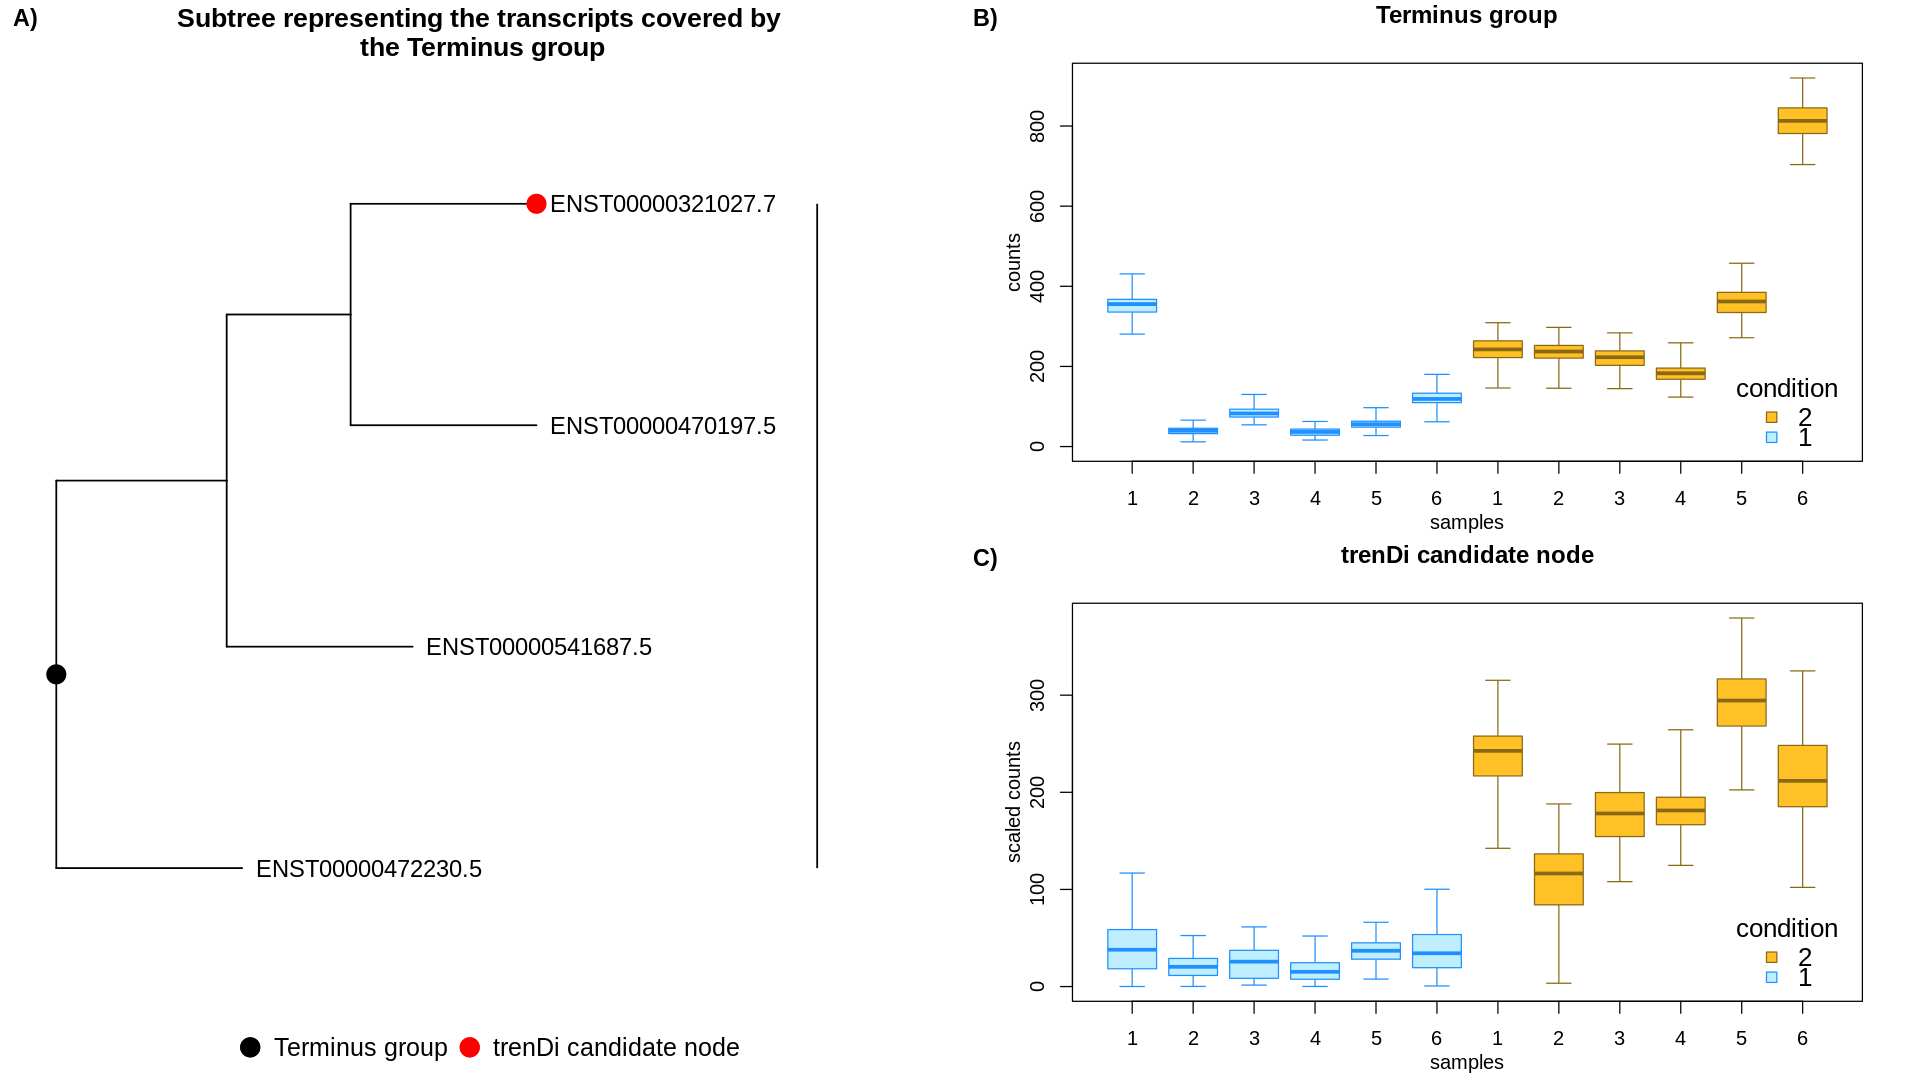

In [23]:
options(repr.plot.width=16, repr.plot.height=9)
cNode <- 112813
tNode <- 462
treeSub <- treeio::tree_subset(treeCons, Ancestors(treeCons,cNode)[3], levels_back = 0)
lNode <- match(treeCons$tip[cNode], treeSub$tip)
iNode <- length(treeSub$tip)+1

of=13.5
pTree <- ggtree(treeSub) + ggtitle("Subtree representing the transcripts covered by \nthe Terminus group") +
    xlim(NA, 55) +
    geom_tiplab(size=5, hjust = -0.05) +
    geom_point2(aes(subset=(node==lNode), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==iNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = lNode, label = "", textcolour="red", 
                  barcolour="red",  fontsize=5, offset = of) + 
    geom_cladelab(node = iNode, label = "", textcolour="black",
                  fontsize=5, offset = of+4) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Terminus group", "trenDi candidate node"),
           values=c("black","red"))

pTerm <- as.grob(~plotInfReps(yAggTermThrNS, as.character(l+tNode), x = "condition", legend = TRUE,
                       main="Terminus group", legendTitle=TRUE, legendCex=1.3,
                       legendPos = "bottomright"))
pTreeTerm <- as.grob(~plotInfReps(yA, cNode, x = "condition", legend=TRUE,
                              main="trenDi candidate node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "bottomright"))
ggarrange(pTree, ggarrange(pTerm, pTreeTerm, ncol = 1, labels = c("B)", "C)")), labels="A)")

#### UnderAgg examples

In [114]:
term <- sapply(underAgg, function(x) x[2])
ug <- sapply(underAgg, function(x) x[1])
ug[order(abs(mcols(yA)[ug,"log2FC"]), decreasing=T)]
term[order(abs(mcols(yA)[ug,"log2FC"]), decreasing=T)]

[1] 237630 237630 235175 229482 213103 213103 240085 240085

[1]  531  531 1184  166 2364 2364 2425 2425

[1] "ENST00000617047.1" "ENST00000618772.4"

[1] "ENST00000618772.4" "ENST00000617047.1" "ENST00000487146.6"
[4] "ENST00000602849.1" "ENST00000369784.7"

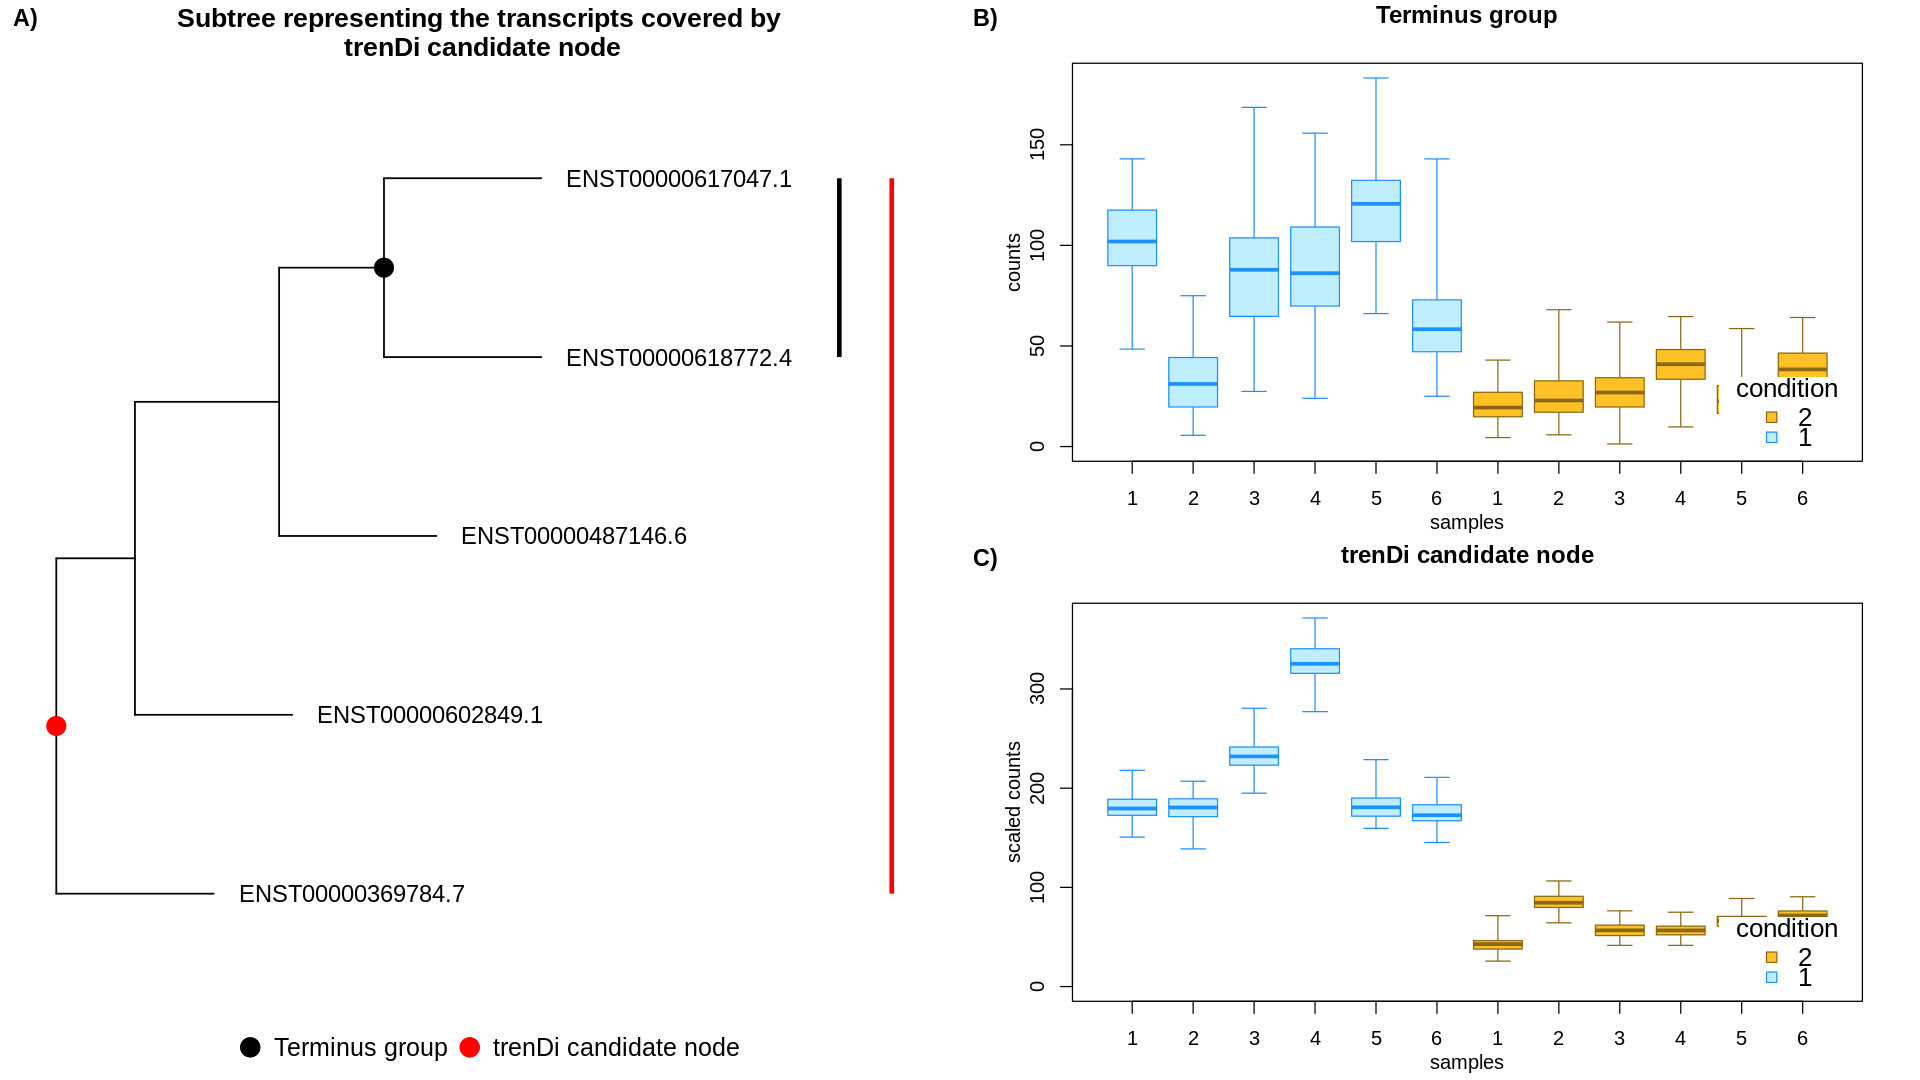

In [25]:
cNode <- 229482
tNode <- 166
rownames(yTermThrNS)[groupsClust[[tNode]]]
treeCons$tip[Descendants(treeCons, cNode)[[1]]]

treeSub <- treeio::tree_subset(treeCons,cNode, levels_back = 0)
n <- length(treeSub$tip) + 1
termNode <- n-1 + n-2
of=22
pTree <- ggtree(treeSub) + ggtitle("Subtree representing the transcripts covered by \ntrenDi candidate node") +
    xlim(NA, 65) +
    geom_tiplab(size=5, hjust = -0.1) +
    geom_point2(aes(subset=(node==n), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==termNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = n, label = "", textcolour="red", 
                  barcolour="red", barsize=1.3, fontsize=5, offset = of+4) + 
    geom_cladelab(node = termNode, label = "", textcolour="black",
                  fontsize=5, barsize=1.3, offset = of) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Terminus group", "trenDi candidate node"),
           values=c("black","red"))

pTerm <- as.grob(~plotInfReps(yAggTermThrNS, as.character(l+tNode), x = "condition", legend = TRUE,
                       main="Terminus group", legendTitle=TRUE, legendCex=1.3, 
                       legendPos = "bottomright"))
pTreeTerm <- as.grob(~plotInfReps(yA, cNode, x = "condition", legend=TRUE,
                              main="trenDi candidate node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "bottomright"))
ggarrange(pTree, ggarrange(pTerm, pTreeTerm, ncol = 1, labels = c("B)", "C)")), labels="A)")

[1] "ENST00000392977.7" "ENST00000392979.7"

[1] "ENST00000550015.1" "ENST00000392979.7" "ENST00000392977.7"

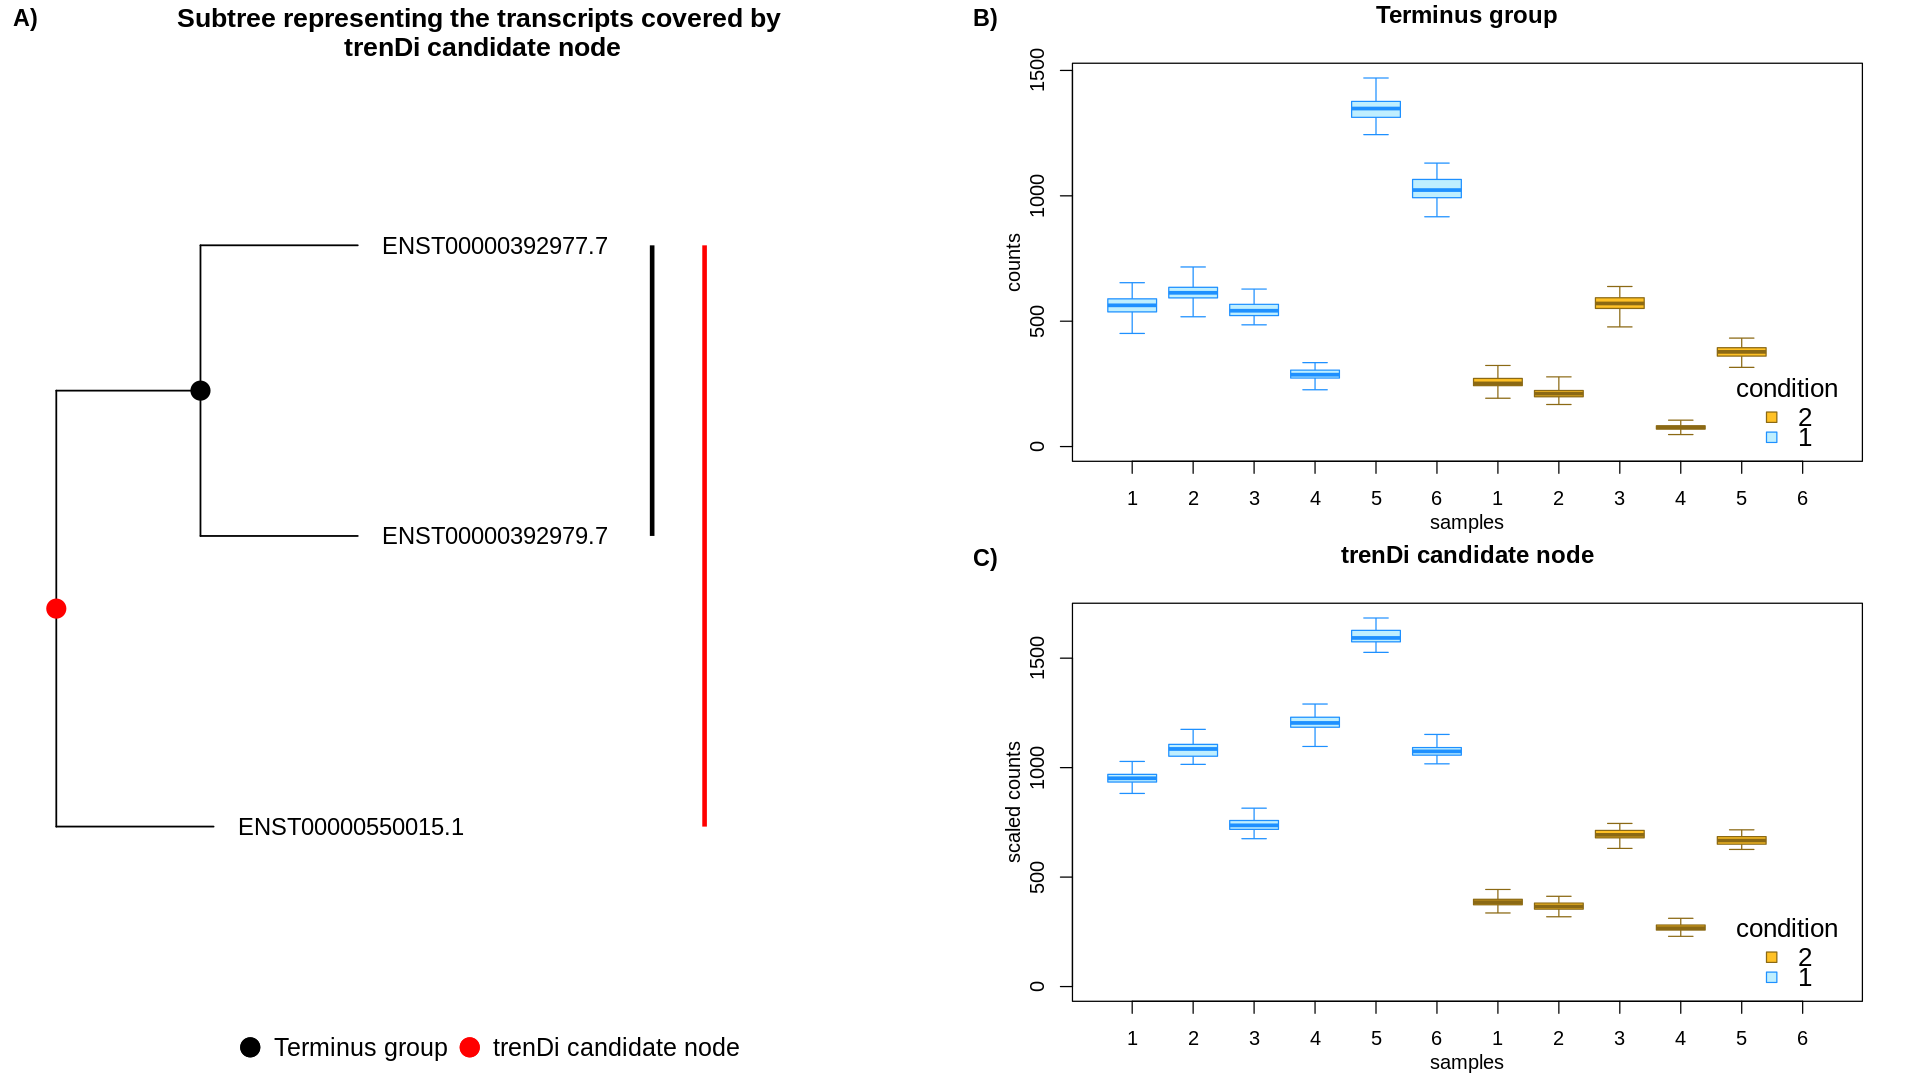

In [26]:
cNode <- 213103
tNode <- 2364
rownames(yTermThrNS)[groupsClust[[tNode]]]
treeCons$tip[Descendants(treeCons, cNode)[[1]]]

treeSub <- treeio::tree_subset(treeCons,cNode, levels_back = 0)
n <- length(treeSub$tip) + 1
termNode <- n-1 + n-2
of=22
pTree <- ggtree(treeSub) + ggtitle("Subtree representing the transcripts covered by \ntrenDi candidate node") +
    xlim(NA, 65) +
    geom_tiplab(size=5, hjust = -0.1) +
    geom_point2(aes(subset=(node==n), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==termNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = n, label = "", textcolour="red", 
                  barcolour="red", barsize=1.3, fontsize=5, offset = of+4) + 
    geom_cladelab(node = termNode, label = "", textcolour="black",
                  fontsize=5, barsize=1.3, offset = of) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Terminus group", "trenDi candidate node"),
           values=c("black","red"))

pTerm <- as.grob(~plotInfReps(yAggTermThrNS, as.character(l+tNode), x = "condition", legend = TRUE,
                       main="Terminus group", legendTitle=TRUE, legendCex=1.3, 
                       legendPos = "bottomright"))
pTreeTerm <- as.grob(~plotInfReps(yA, cNode, x = "condition", legend=TRUE,
                              main="trenDi candidate node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "bottomright"))
ggarrange(pTree, ggarrange(pTerm, pTreeTerm, ncol = 1, labels = c("B)", "C)")), labels="A)")

[1] "ENST00000450056.6" "ENST00000443047.6"

[1] "ENST00000443047.6"  "ENST00000450056.6"  "ENST00000432561.6" 
[4] "ENST00000315585.11" "ENST00000544268.5"  "ENST00000544093.5"

Warning message:
"Removed 1 rows containing missing values (`geom_text()`)."


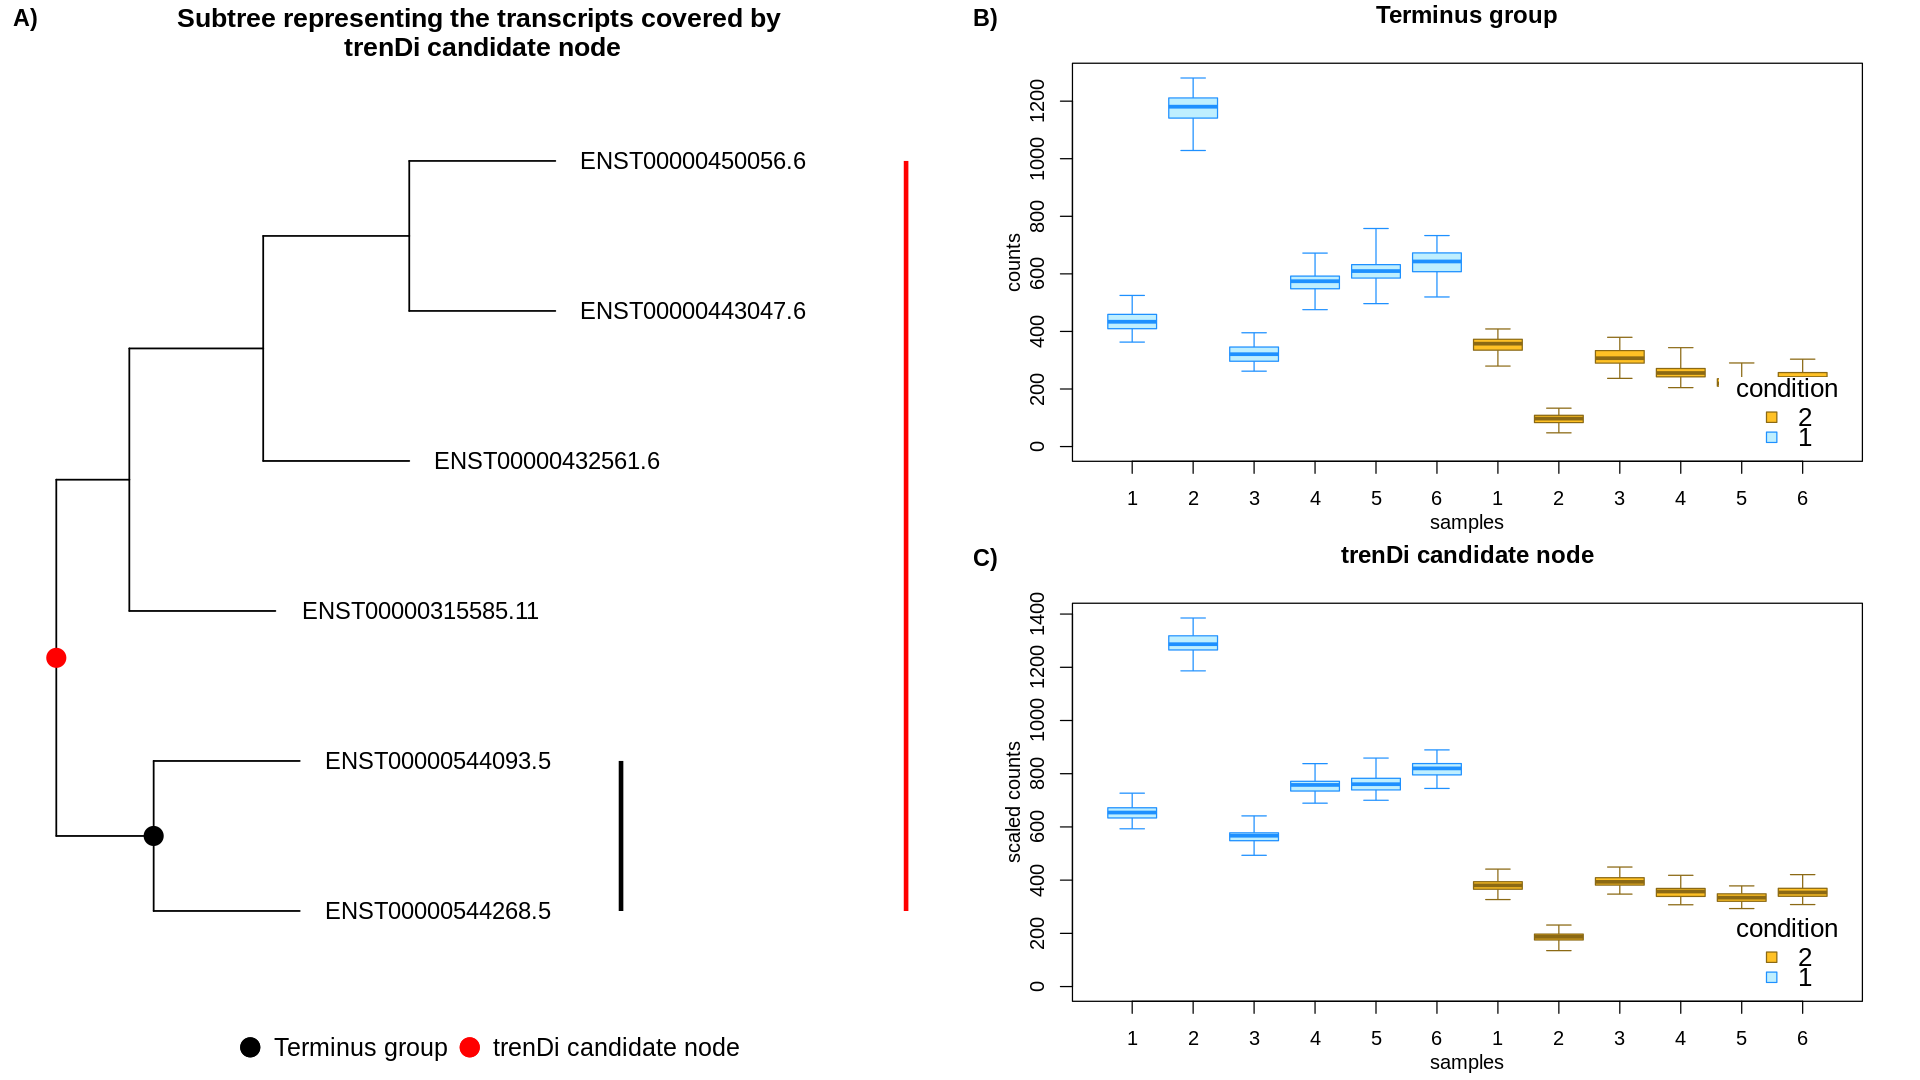

In [29]:
cNode <- 240085
tNode <- 2425
rownames(yTermThrNS)[groupsClust[[tNode]]]
treeCons$tip[Descendants(treeCons, cNode)[[1]]]

treeSub <- treeio::tree_subset(treeCons,cNode, levels_back = 0)
n <- length(treeSub$tip) + 1
termNode <- n-1 + n-2
of=26
pTree <- ggtree(treeSub) + ggtitle("Subtree representing the transcripts covered by \ntrenDi candidate node") +
    xlim(NA, 70) +
    geom_tiplab(size=5, hjust = -0.1) +
    geom_point2(aes(subset=(node==n), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==termNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = n, label = "", textcolour="red", 
                  barcolour="red", barsize=1.3, fontsize=5, offset = of+2) + 
    geom_cladelab(node = termNode, label = "", textcolour="black",
                  fontsize=5, barsize=1.3, offset = of) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Terminus group", "trenDi candidate node"),
           values=c("black","red"))

pTerm <- as.grob(~plotInfReps(yAggTermThrNS, as.character(l+tNode), x = "condition", legend = TRUE,
                       main="Terminus group", legendTitle=TRUE, legendCex=1.3, 
                       legendPos = "bottomright"))
pTreeTerm <- as.grob(~plotInfReps(yA, cNode, x = "condition", legend=TRUE,
                              main="trenDi candidate node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "bottomright"))
ggarrange(pTree, ggarrange(pTerm, pTreeTerm, ncol = 1, labels = c("B)", "C)")), labels="A)")

In [31]:
head(cNodesU[order(abs(mcols(yA)[cNodesU,"log2FC"]), decreasing=T)],20)
head(order(abs(mcols(yA)[cNodesU,"log2FC"]), decreasing=T),20)
desc <- Descendants(treeCons, cNodesU)

[1] 163102  96952 237630 169755 216928  32699  76487 166802  54827 217147
[11]  38072  72312  52445 225317 172282 165813 210453 132747 174031 223489

[1] 62 36 43 16 25 63 29  4  9 34 54 28 31 73 60 56  3 76 50 27


Phylogenetic tree with 3 tips and 2 internal nodes.

Tip labels:
  ENST00000451436.6, ENST00000374719.7, ENST00000396050.5
Node labels:
  Node216928, Node216929

Rooted; includes branch lengths.

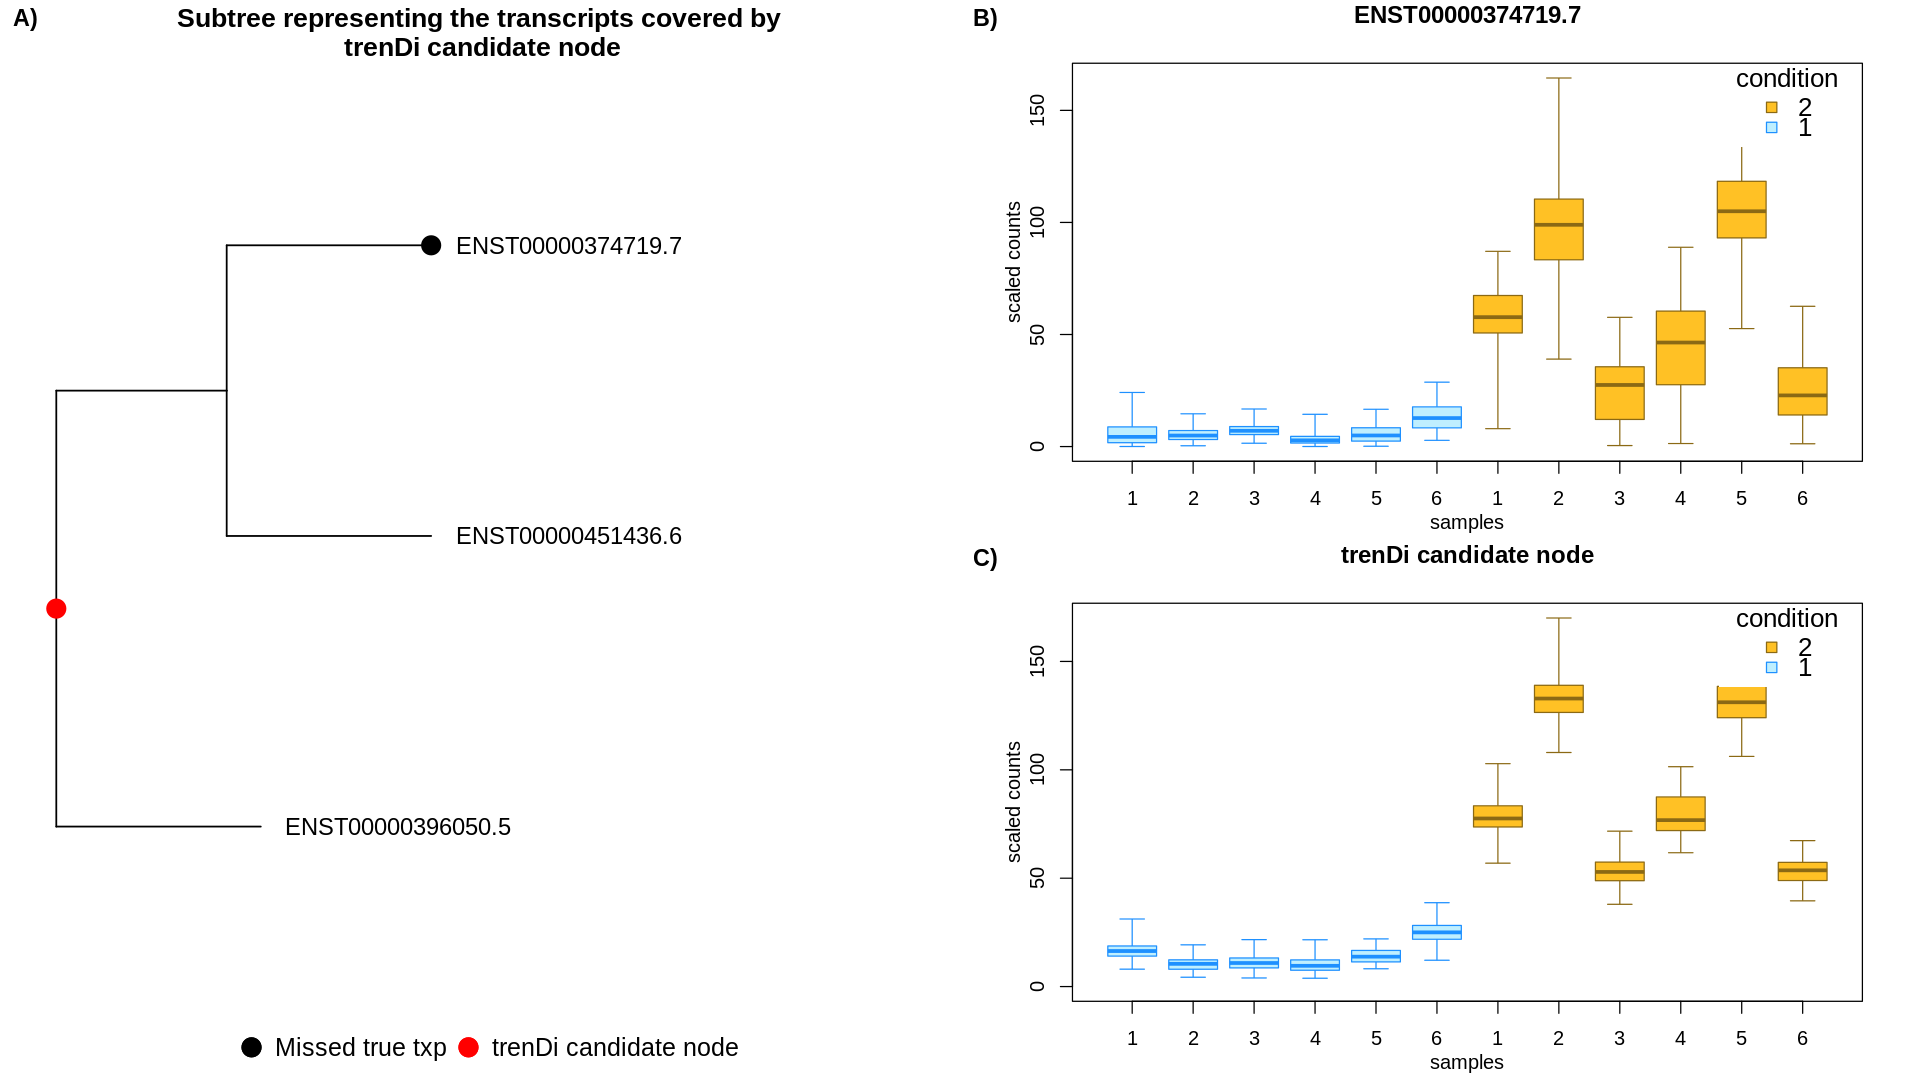

In [32]:
i <- 25
cNode <- cNodesU[[i]]
tInd <- desc[[i]][desc[[i]] %in% match(dts, treeCons$tip)]


treeSub <- treeio::tree_subset(treeCons, cNode, levels_back = 0)
treeSub
of=20

rNode <- length(treeSub$tip)+1
lNode <- match(treeCons$tip[tInd], treeSub$tip)
pTree <- ggtree(treeSub) + ggtitle("Subtree representing the transcripts covered by \ntrenDi candidate node") +
    xlim(NA, 50) +
    geom_tiplab(size=5, hjust = -0.1) +
    geom_point2(aes(subset=(node==rNode), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==lNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = 3, label = "", textcolour="red", 
                  barcolour="red", barsize=1.3, fontsize=5, offset = of+5) + 
    
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Missed true txp", "trenDi candidate node"),
           values=c("black","red"))

pTxp <- as.grob(~plotInfReps(yA, tInd, x = "condition", legend = TRUE,
                       main=paste(treeCons$tip[tInd]), legendTitle=TRUE, legendCex=1.3,
                       legendPos = "topright"))
pTreeTerm <- as.grob(~plotInfReps(yA, cNode, x = "condition", legend=TRUE,
                              main="trenDi candidate node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "topright"))
ggarrange(pTree, ggarrange(pTxp, pTreeTerm, ncol = 1, labels = c("B)", "C)")), labels="A)")

[1] 32691 32692


Phylogenetic tree with 2 tips and 1 internal nodes.

Tip labels:
  ENST00000473511.5, ENST00000464570.1
Node labels:
  Node163102

Rooted; includes branch lengths.

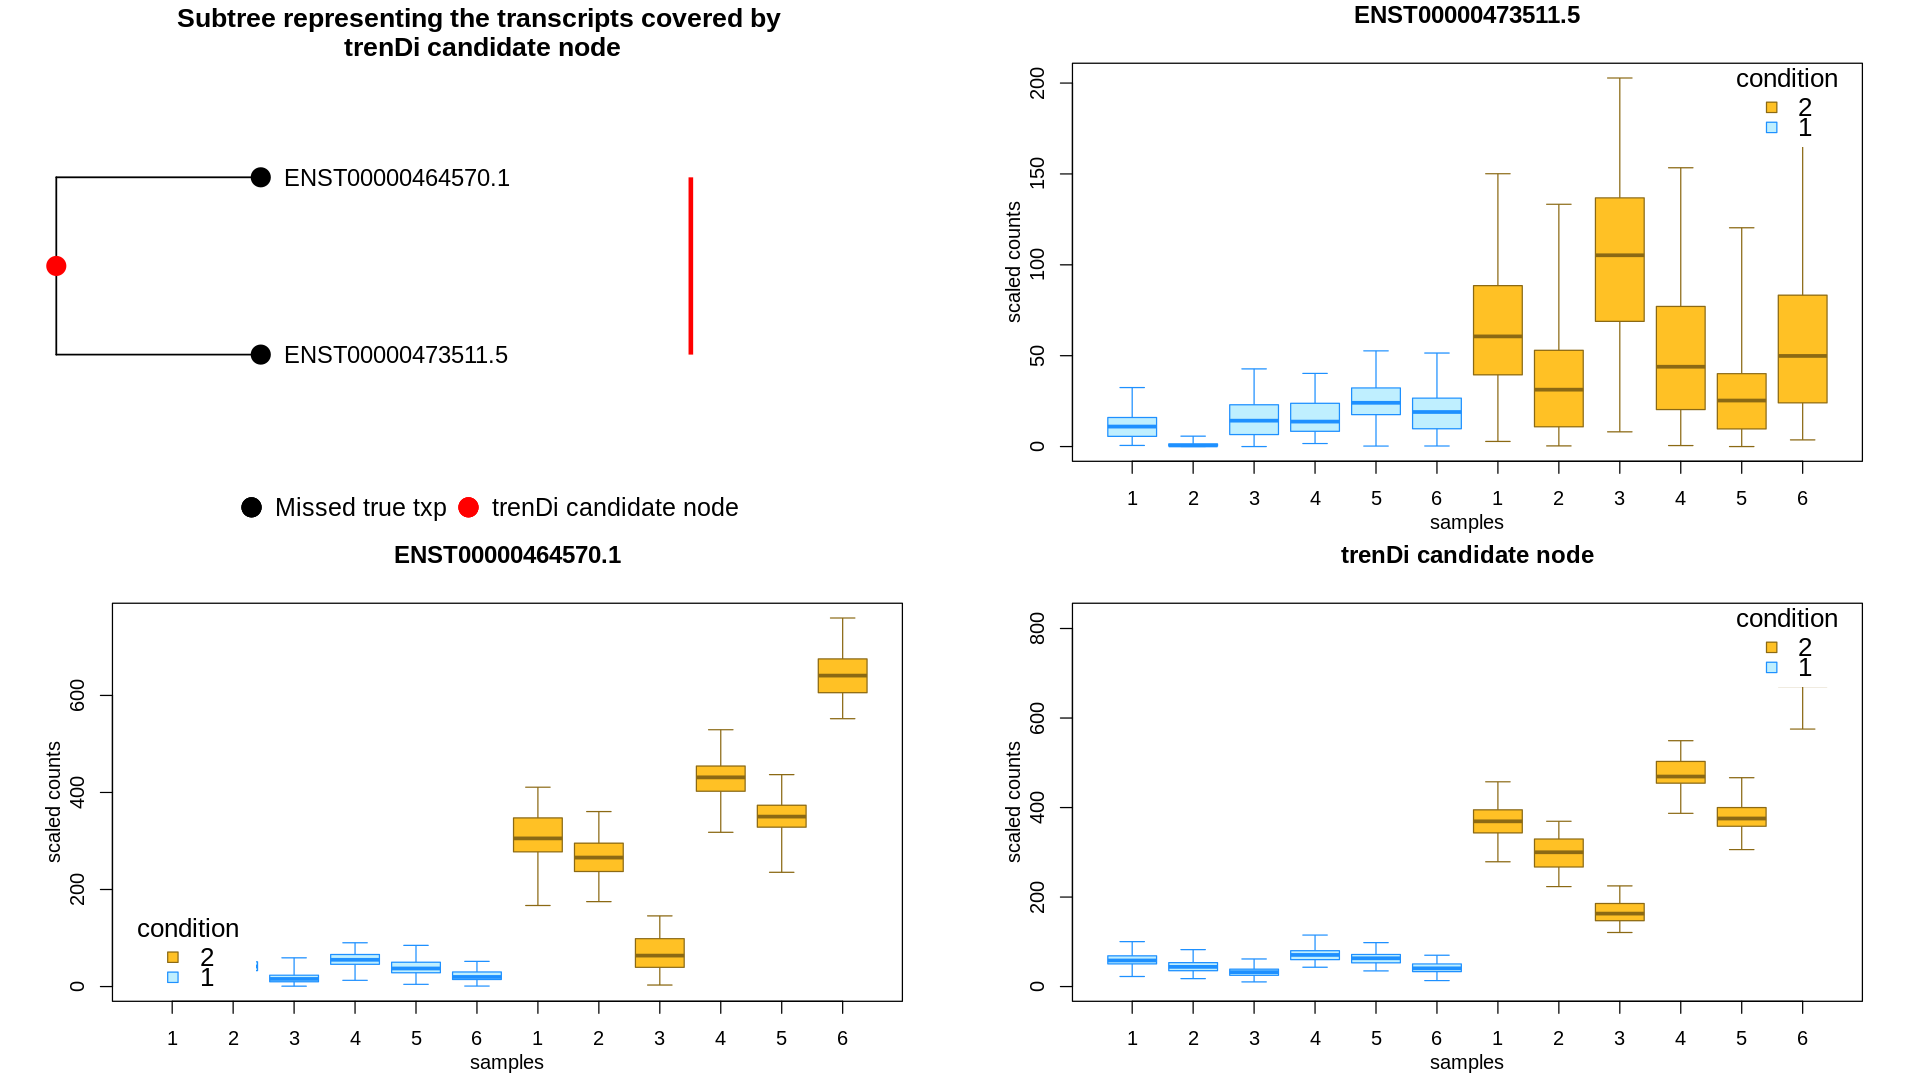

In [33]:
i <- 62
cNode <- cNodesU[[i]]
tInd <- desc[[i]][desc[[i]] %in% match(dts, treeCons$tip)]
tInd

treeSub <- treeio::tree_subset(treeCons, cNode, levels_back = 0)
treeSub
of=20

rNode <- length(treeSub$tip)+1
lNode <- match(treeCons$tip[tInd], treeSub$tip)
pTree <- ggtree(treeSub) + ggtitle("Subtree representing the transcripts covered by \ntrenDi candidate node") +
    xlim(NA, 50) +
    geom_tiplab(size=5, hjust = -0.1) +
    geom_point2(aes(subset=(node==rNode), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==lNode[1]), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_point2(aes(subset=(node==lNode[2]), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = 3, label = "", textcolour="red", 
                  barcolour="red", barsize=1.3, fontsize=5, offset = of+5) + 
    
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Missed true txp", "trenDi candidate node"),
           values=c("black","red"))

pTxp1 <- as.grob(~plotInfReps(yA, tInd[1], x = "condition", legend = TRUE,
                       main=treeCons$tip[tInd[1]], legendTitle=TRUE, legendCex=1.3,
                       legendPos = "topright"))
pTxp2 <- as.grob(~plotInfReps(yA, tInd[2], x = "condition", legend = TRUE,
                       main=treeCons$tip[tInd[2]], legendTitle=TRUE, legendCex=1.3,
                       legendPos = "bottomleft"))
pTreeTerm <- as.grob(~plotInfReps(yA, cNode, x = "condition", legend=TRUE,
                              main="trenDi candidate node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "topright"))
ggarrange(pTree, pTxp1, pTxp2, pTreeTerm)

[1] 87411 87412


Phylogenetic tree with 3 tips and 2 internal nodes.

Tip labels:
  ENST00000010132.6, ENST00000540757.6, ENST00000543431.5
Node labels:
  Node210453, Node210454

Rooted; includes branch lengths.

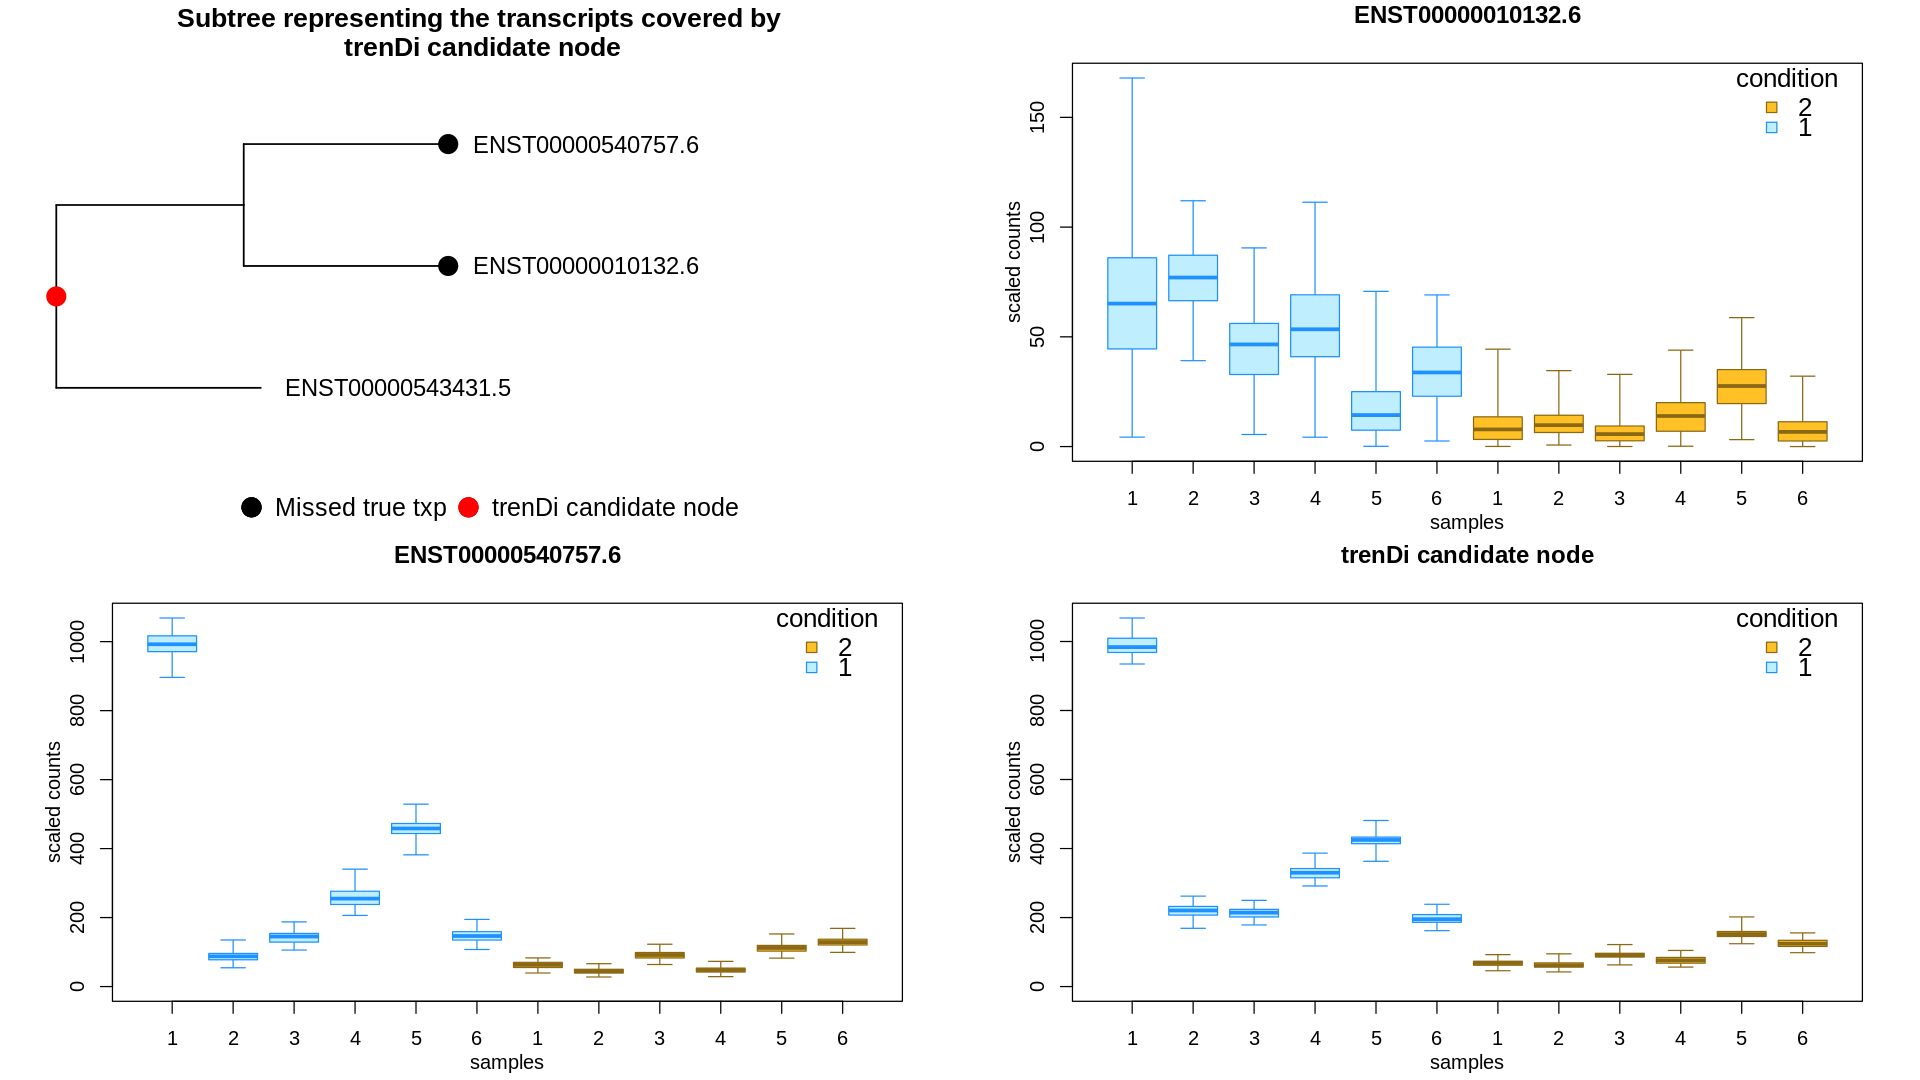

In [34]:
i <- 3
cNode <- cNodesU[[i]]
tInd <- desc[[i]][desc[[i]] %in% match(dts, treeCons$tip)]
tInd

treeSub <- treeio::tree_subset(treeCons, cNode, levels_back = 0)
treeSub
of=20

rNode <- length(treeSub$tip)+1
lNode <- match(treeCons$tip[tInd], treeSub$tip)
pTree <- ggtree(treeSub) + ggtitle("Subtree representing the transcripts covered by \ntrenDi candidate node") +
    xlim(NA, 50) +
    geom_tiplab(size=5, hjust = -0.1) +
    geom_point2(aes(subset=(node==rNode), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==lNode[1]), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_point2(aes(subset=(node==lNode[2]), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = 3, label = "", textcolour="red", 
                  barcolour="red", barsize=1.3, fontsize=5, offset = of+5) + 
    
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Missed true txp", "trenDi candidate node"),
           values=c("black","red"))

pTxp1 <- as.grob(~plotInfReps(yA, tInd[1], x = "condition", legend = TRUE,
                       main=treeCons$tip[tInd[1]], legendTitle=TRUE, legendCex=1.3,
                       legendPos = "topright"))
pTxp2 <- as.grob(~plotInfReps(yA, tInd[2], x = "condition", legend = TRUE,
                       main=treeCons$tip[tInd[2]], legendTitle=TRUE, legendCex=1.3,
                       legendPos = "topright"))
pTreeTerm <- as.grob(~plotInfReps(yA, cNode, x = "condition", legend=TRUE,
                              main="trenDi candidate node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "topright"))
ggarrange(pTree, pTxp1, pTxp2, pTreeTerm)